In [1]:
%pylab notebook
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
pathout = "../figures/" + "data_compression/"
! mkdir $pathout

mkdir: ../figures/data_compression/: File exists


In [3]:
h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1

# Moment expansion for a modified black body spectra
def y1(x):
    return x*exp(x)/(exp(x)-1.)

def y2(x):
    return y1(x)*x*cosh(0.5*x)/sinh(0.5*x)

def y3(x):
    return y1(x)*x*x*(cosh(x)+2)/(cosh(x)-1)

def y4(x):
    return y2(x)*0.5*x*x*(cosh(x)+5)/(sinh(0.5*x)**2.)

def y5(x):
    return y1(x)*(x**4.)*(33.+26*cosh(x)+cosh(2.*x))/(8.*sinh(0.5*x)**4.)

def f_mbb(nu,T,alpha,A,p22,p23,p33,p222,p223,p233,p333):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + 0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. + 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) + p333*y3(x)/6.)
    return temp

In [4]:
def mbb(nu,T,alpha,A,nu0=1.):
    x=h*nu*1e9/(k*T)
    Inu=A*((nu/nu0)**alpha)*(nu**3.)/(exp(x)-1.)
    return Inu

def int_mbb_spectra(nu,T_dist,alpha_dist,nu0=1.):
    Inu=zeros(size(nu),float)
    for i in range(size(T_dist)):
            Inu=Inu + mbb(nu,T_dist[i],alpha_dist[i],A=1.,nu0=nu0)
    return Inu/size(T_dist)

# Generating the distribution of parameters

<IPython.core.display.Javascript object>


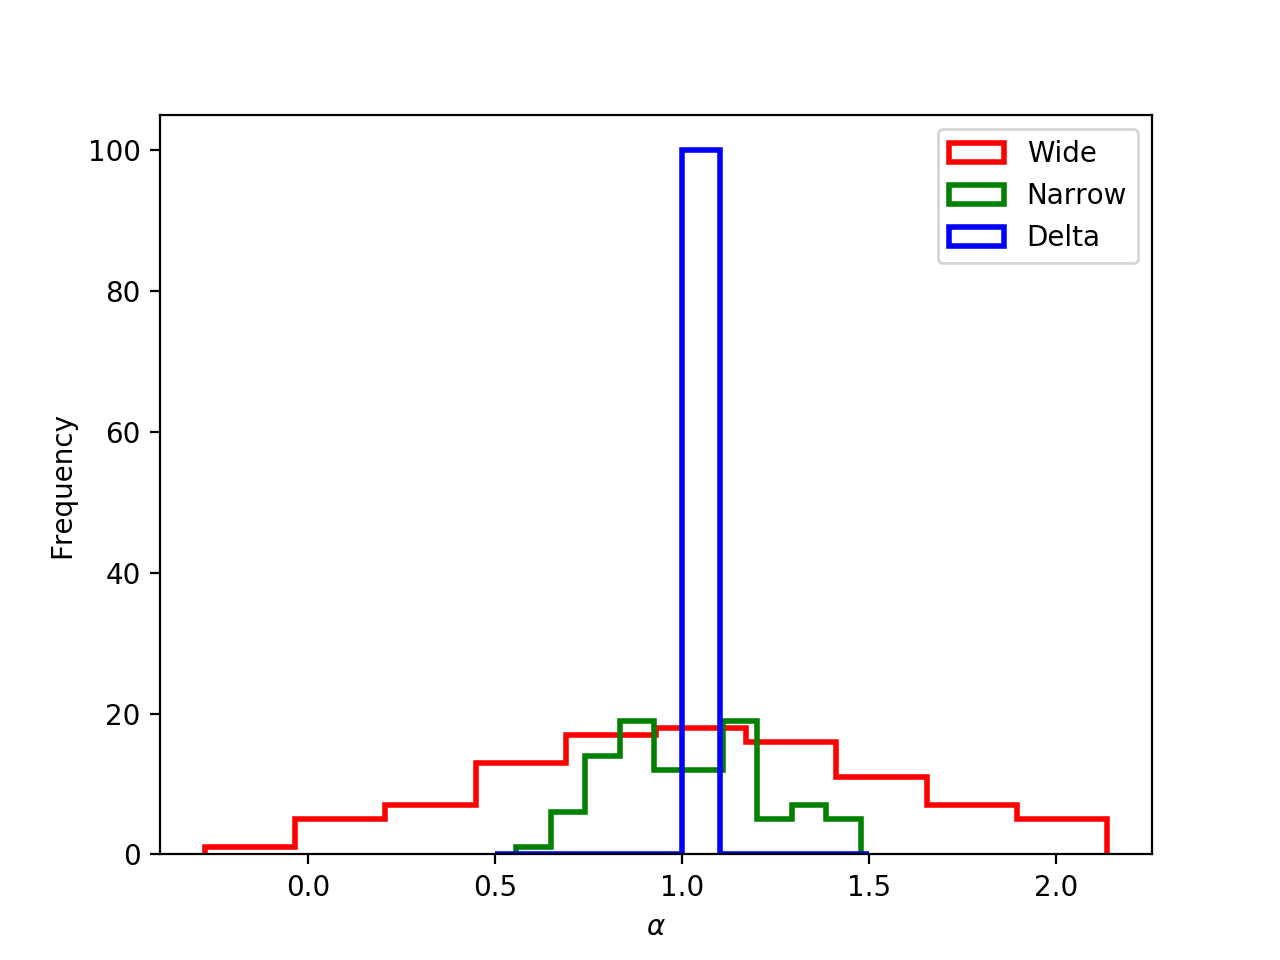

<IPython.core.display.Javascript object>


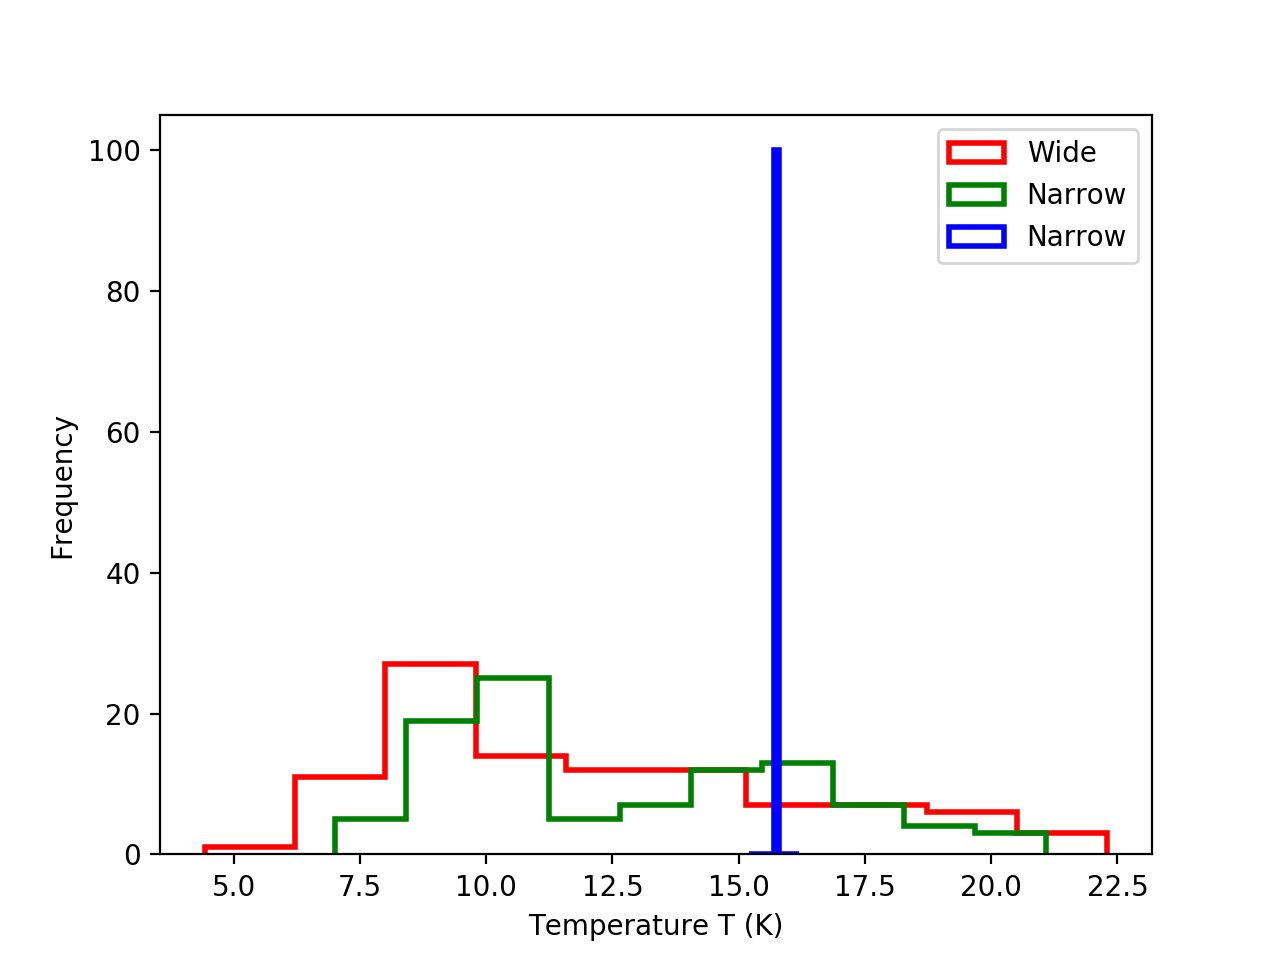

In [5]:
N=100 ;
random.seed(0)
alpha0=1. ; std_alpha=0.5 ; alpha_wide=alpha0 + std_alpha*randn(N)
alpha0=1. ; std_alpha=0.2 ; alpha_narrow=alpha0 + std_alpha*randn(N)
alpha0=1. ; std_alpha=0.0 ; alpha_delta=alpha0 + std_alpha*randn(N)

T1=9.75 ; T2=15.7 ; std_T1=2 ; std_T2=4 ; T_wide=append(random.normal(T1,std_T1,N/2),random.normal(T2,std_T2,N/2))
T1=9.75 ; T2=15.7 ; std_T1=1. ; std_T2=2 ; T_narrow=append(random.normal(T1,std_T1,N/2),random.normal(T2,std_T2,N/2))
T1=0. ; T2=15.7 ; std_T=0. ; std_T2=0 ; T_delta=ones(N)*T2

figure()
hist(alpha_wide,histtype="step",color="red",linewidth=2,label="Wide")
hist(alpha_narrow,histtype="step",color="green",linewidth=2,label="Narrow")
hist(alpha_delta,histtype="step",color="blue",linewidth=2,label="Delta")
legend(loc=0)
xlabel(r"$\alpha$")
ylabel("Frequency")
savefig(pathout + "alpha_distribution.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "alpha_distribution.jpeg",dpi=150,bbox_inches="tight")

figure()
hist(T_wide,histtype="step",color="red",linewidth=2,label="Wide")
hist(T_narrow,histtype="step",color="green",linewidth=2,label="Narrow")
hist(T_delta,histtype="step",color="blue",linewidth=2,label="Narrow")
xlabel(r"Temperature T (K)")
ylabel("Frequency")
legend(loc=0)
savefig(pathout + "T_distribution.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "T_distribution.jpeg",dpi=150,bbox_inches="tight")

# Generating the model SED

<IPython.core.display.Javascript object>


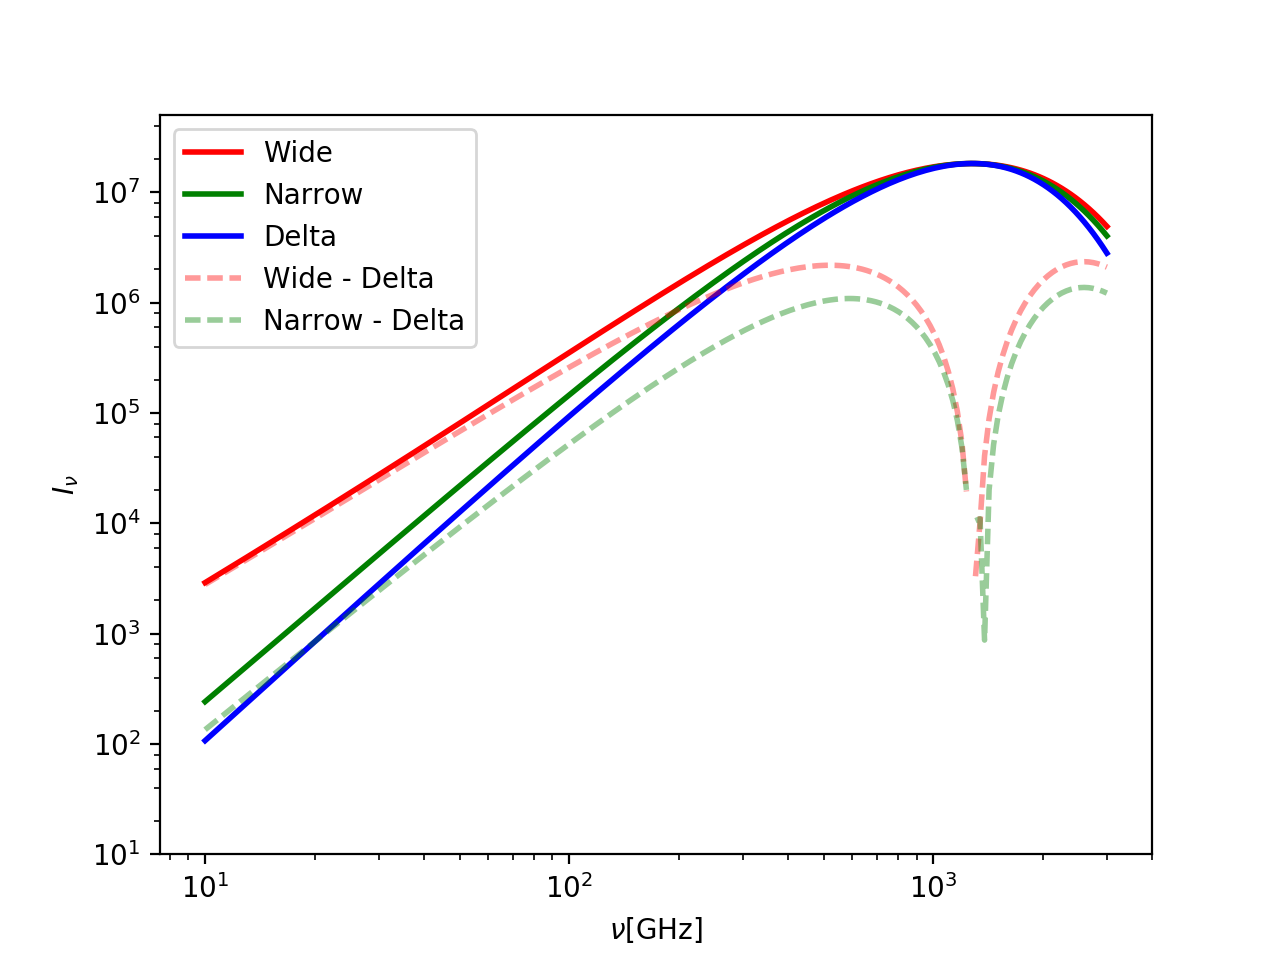

In [6]:
nu=logspace(log10(10),log10(3000),200)


Inu_delta=int_mbb_spectra(nu,T_delta,alpha_delta,nu0=3000.) ; nu0=nu[Inu_delta==max(Inu_delta)]
Inu_wide=int_mbb_spectra(nu,T_wide,alpha_wide,nu0=3000.) ; Inu_wide=Inu_wide*Inu_delta[nu==nu0]/Inu_wide[nu==nu0]
Inu_narrow=int_mbb_spectra(nu,T_narrow,alpha_narrow,nu0=3000.) ; Inu_narrow=Inu_narrow*Inu_delta[nu==nu0]/Inu_narrow[nu==nu0]

figure()
s=0.
plot(nu,Inu_wide/(nu**s),"r-",lw=2,label="Wide")
plot(nu,Inu_narrow/(nu**s),"g-",lw=2,label="Narrow")
plot(nu,Inu_delta/(nu**s),"b-",lw=2,label="Delta")
plot(nu,abs(Inu_wide-Inu_delta)/(nu**s),"r--",lw=2,alpha=0.4,label="Wide - Delta")
plot(nu,abs(Inu_narrow-Inu_delta)/(nu**s),"g--",lw=2,alpha=0.4,label="Narrow - Delta")
legend(loc=0)
loglog()
ylim(1e1,5e7)
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
savefig(pathout + "model_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "model_sed.jpeg",dpi=150,bbox_inches="tight")

# Wide

In [7]:
Inu=zeros(size(nu),float) ; Inu[:] = Inu_wide[:]
p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=2.
p0=(5.,1.,1.,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

p0=append(fitp1,(0.,0.,0.,0.))
#p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.)
lb2=append(lb1,[-prange,-prange,-prange,-prange])
ub2=append(ub1,[prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333), nu,Inu,p0,maxfev=2000000)#,bounds=[lb2,ub2],maxfev=200000)
print fitp2

[ 20.53049961   0.17454099   0.13666749]
[  1.76218072e+01   3.39535918e-01   1.53487540e-01  -1.77784194e-03
  -3.11311355e-02   4.73375398e-02]
[ 16.58409458   0.5396517    0.13578154  -0.13692813  -0.11509309
   0.14681722  -0.19009792   0.22188328  -0.12039674   0.03694012]


<IPython.core.display.Javascript object>


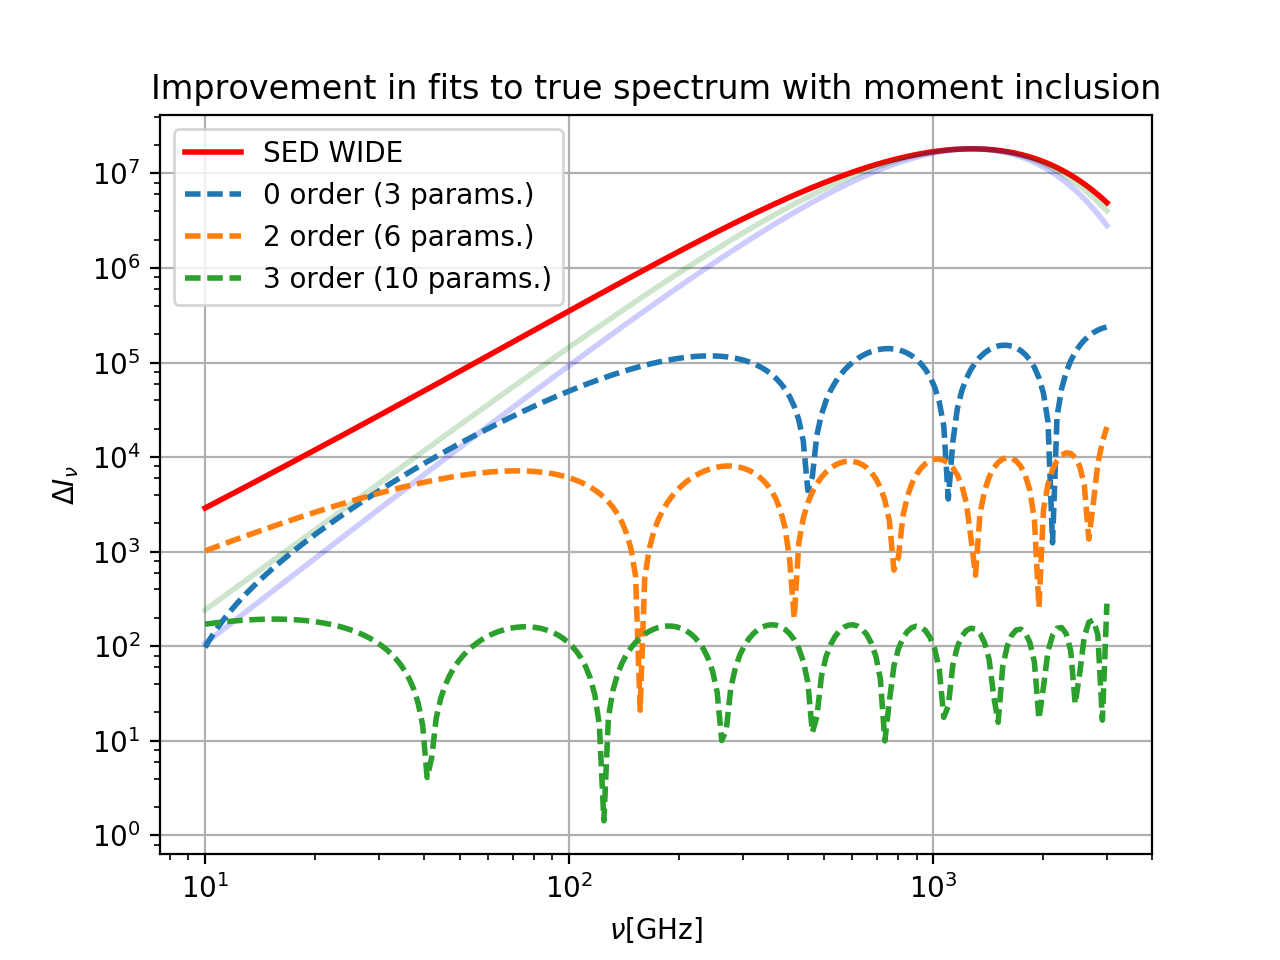

<IPython.core.display.Javascript object>


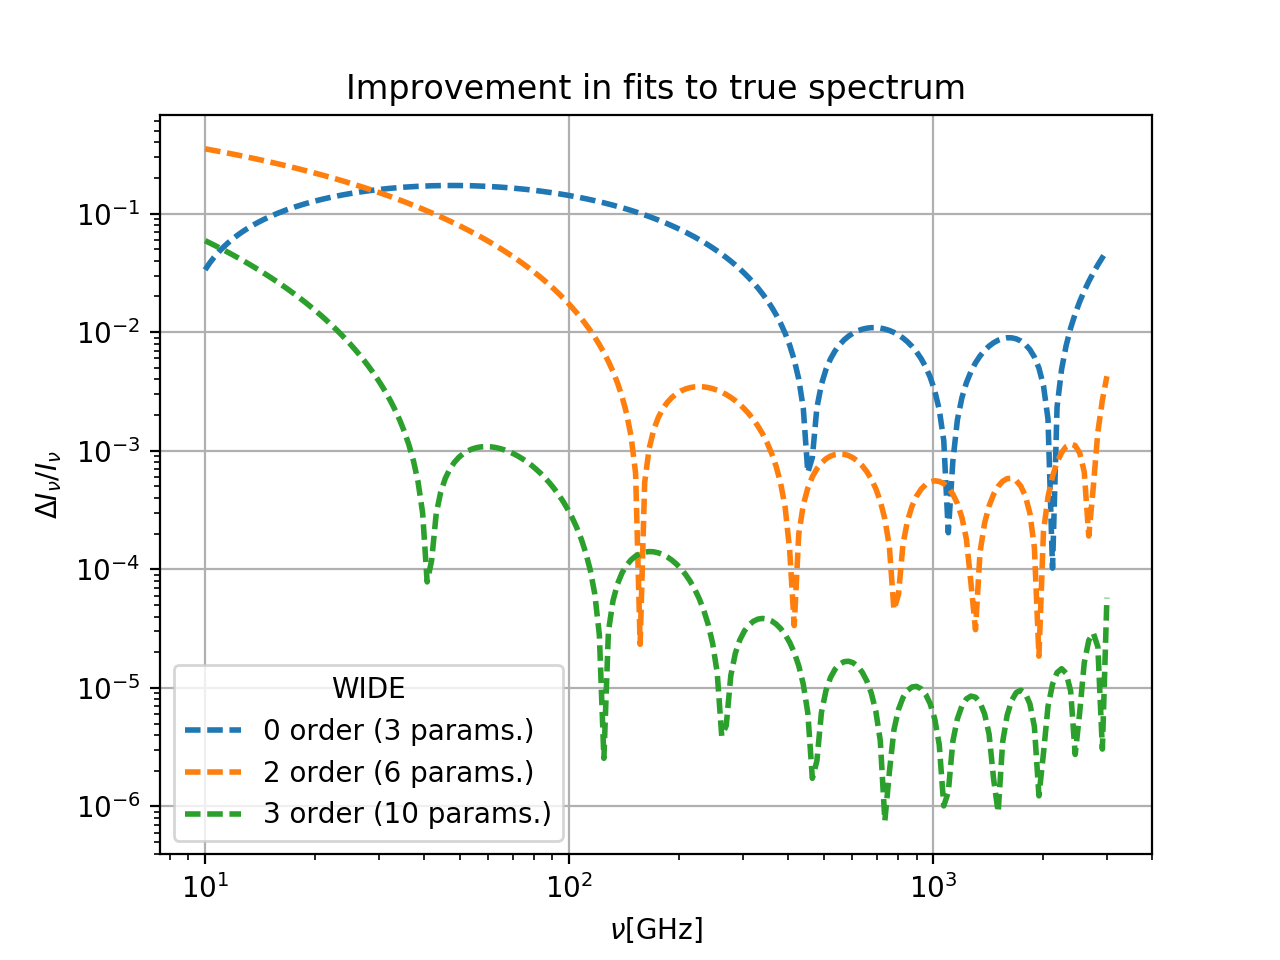

<IPython.core.display.Javascript object>


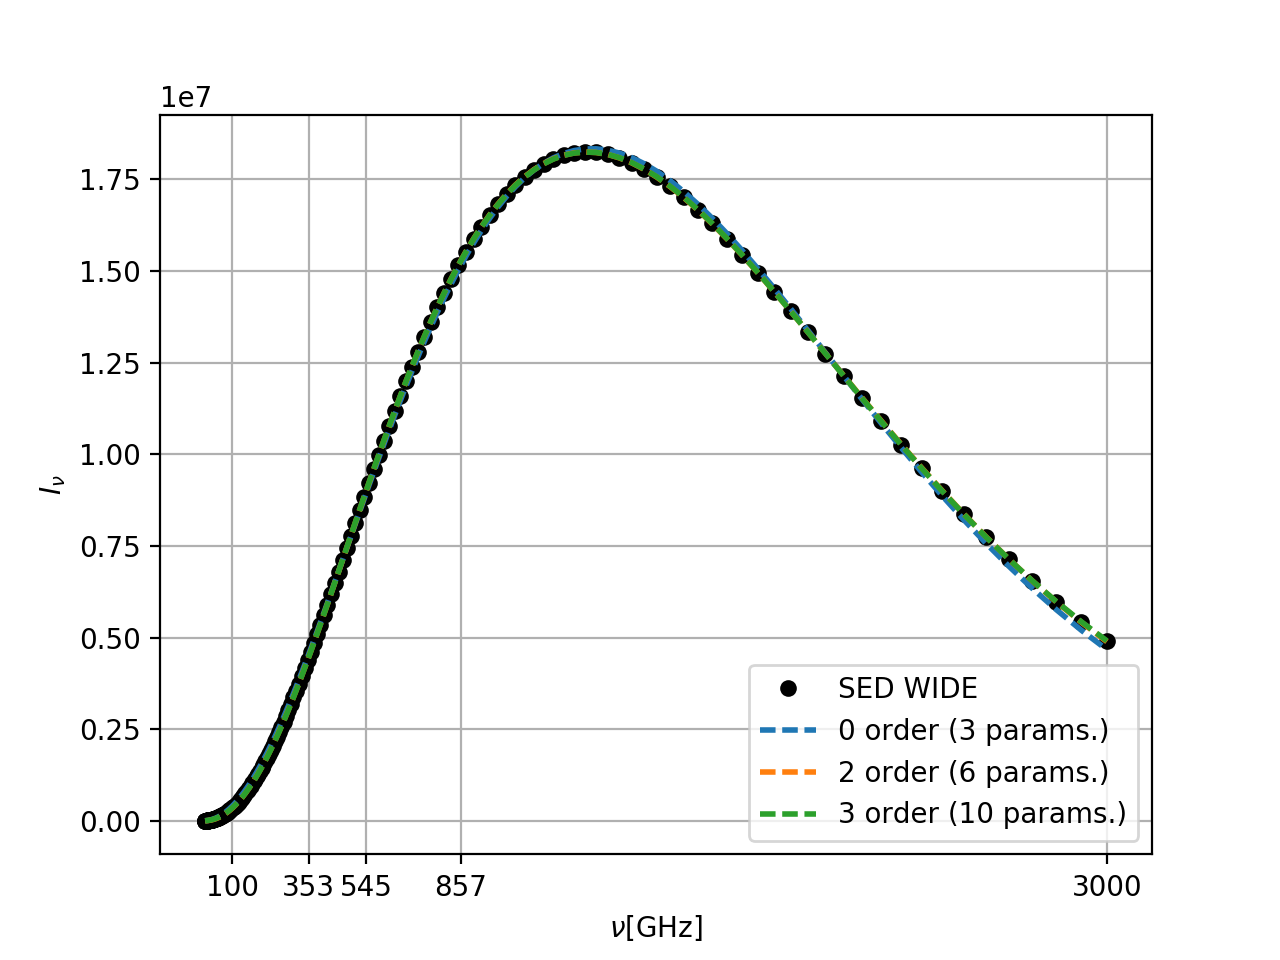

In [8]:
figure()
title("Improvement in fits to true spectrum with moment inclusion")
plot(nu,Inu_wide,"r-",lw=2,label="SED WIDE")
plot(nu,Inu_narrow,"g-",lw=2,alpha=0.2)
plot(nu,Inu_delta,"b-",lw=2,alpha=0.2)
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])),"--",lw=2,label=pllabel)
semilogy()
loglog()
grid()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
legend(loc=0)
savefig(pathout + "improvement_in_fits_wide_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "improvement_in_fits_wide_sed.jpeg",dpi=150,bbox_inches="tight")

figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$\Delta I_{\nu}/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
#xticks([100,143,217,353,545,857],[100,143,217,353,545,857])
grid()
#ylim(1e-5,1e-1)
legend(loc=0,title="WIDE")
savefig(pathout + "relative_error_with_taylor_order_wide_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order_wide_sed.jpeg",dpi=150,bbox_inches="tight")


figure()
sl=0.
title("")
plot(nu,Inu/(nu**sl),"ko",mec="none",lw=4,alpha=1.,label="SED WIDE")
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
#ylabel(r"$I_{\nu}/ \nu^{3}$")
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])
savefig(pathout + "inu_fit_with_taylor_order_wide_sed.pdf",dpi=150,bbox_inches="tight")

# Narrow

In [18]:
Inu=zeros(size(nu),float) ; Inu[:] = Inu_narrow[:]
p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=2.
p0=(5.,1.,1.,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

#p0=append(fitp1,(0.,0.,0.,0.))
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.)
lb2=append(lb1,[-prange,-prange,-prange,-prange])
ub2=append(ub1,[prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333), nu,Inu,p0,maxfev=2000000)#,bounds=[lb2,ub2],maxfev=200000)
print fitp2

[ 17.96532025   0.56162226   0.12965348]
[  1.59762539e+01   7.75355803e-01   1.32259793e-01  -1.40395111e-01
  -6.80894480e-03   2.82719940e-02]
[  1.48183866e+01   1.17374603e+00   1.36115581e-01  -1.04106106e-01
  -1.68949725e-01   2.29235110e-02  -4.35640809e-03   3.07776255e-01
  -7.28591292e-02   2.14420444e-02]


<IPython.core.display.Javascript object>


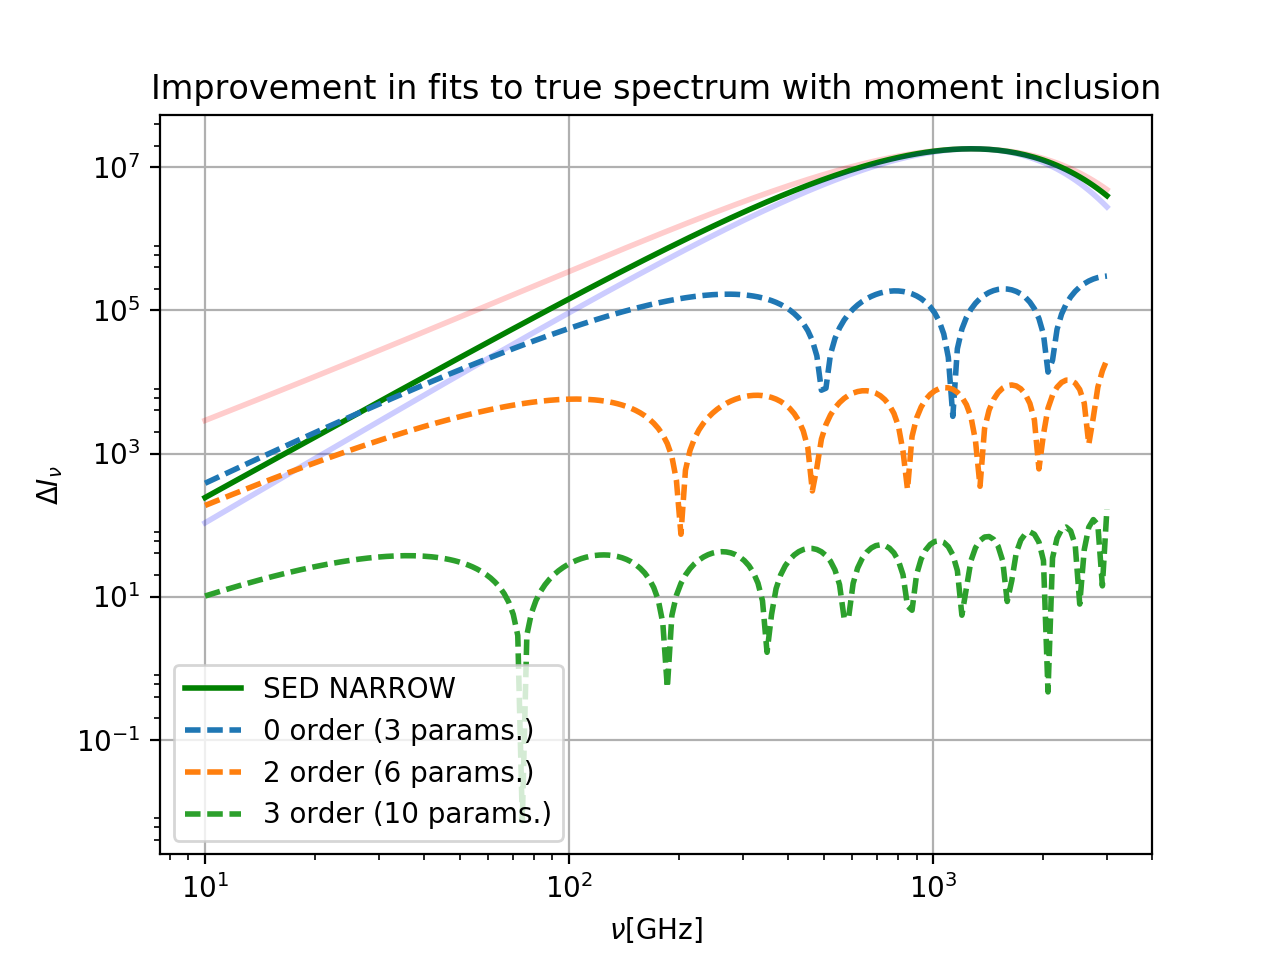

<IPython.core.display.Javascript object>


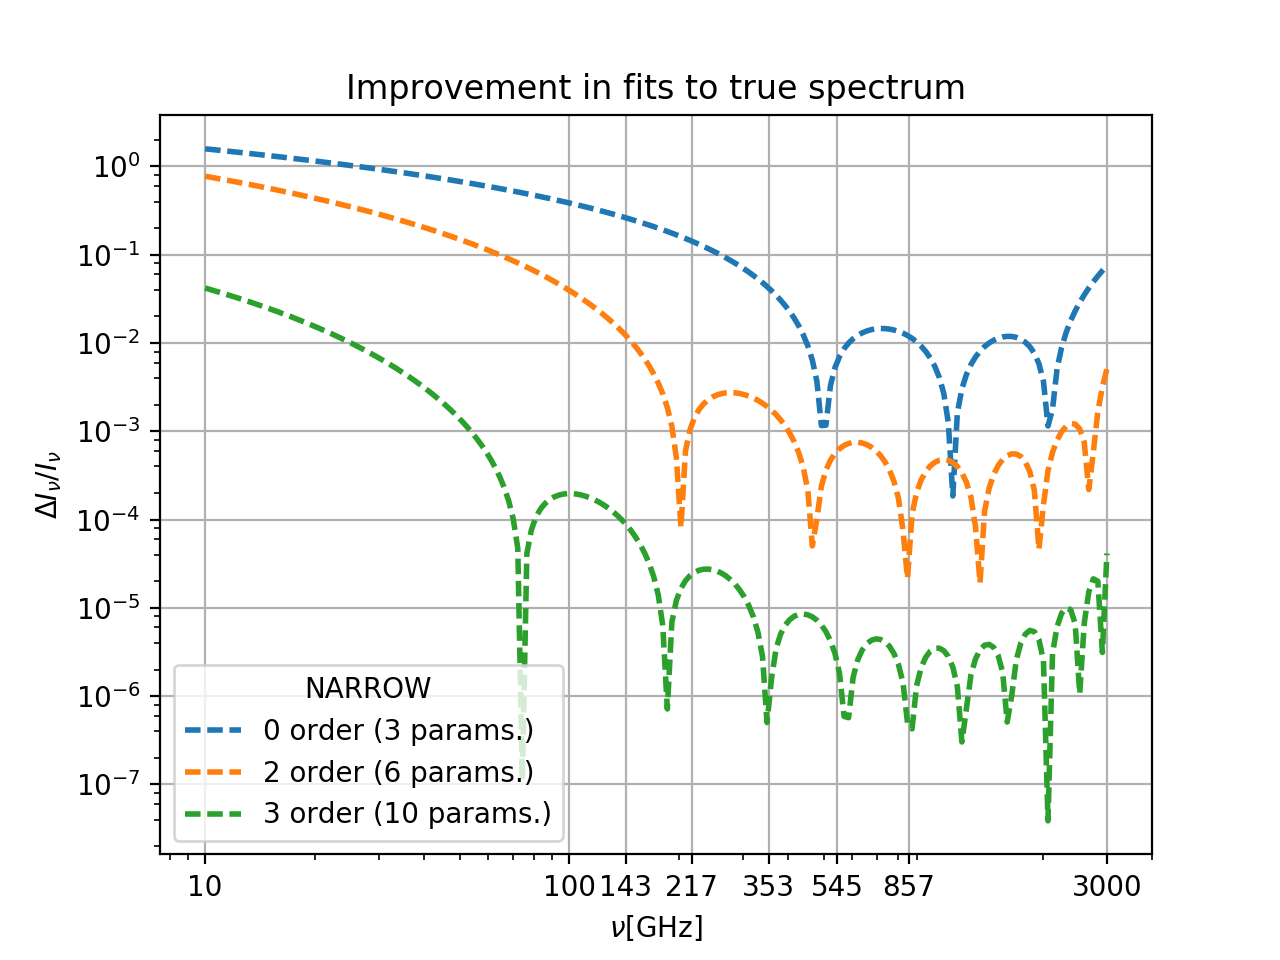

<IPython.core.display.Javascript object>


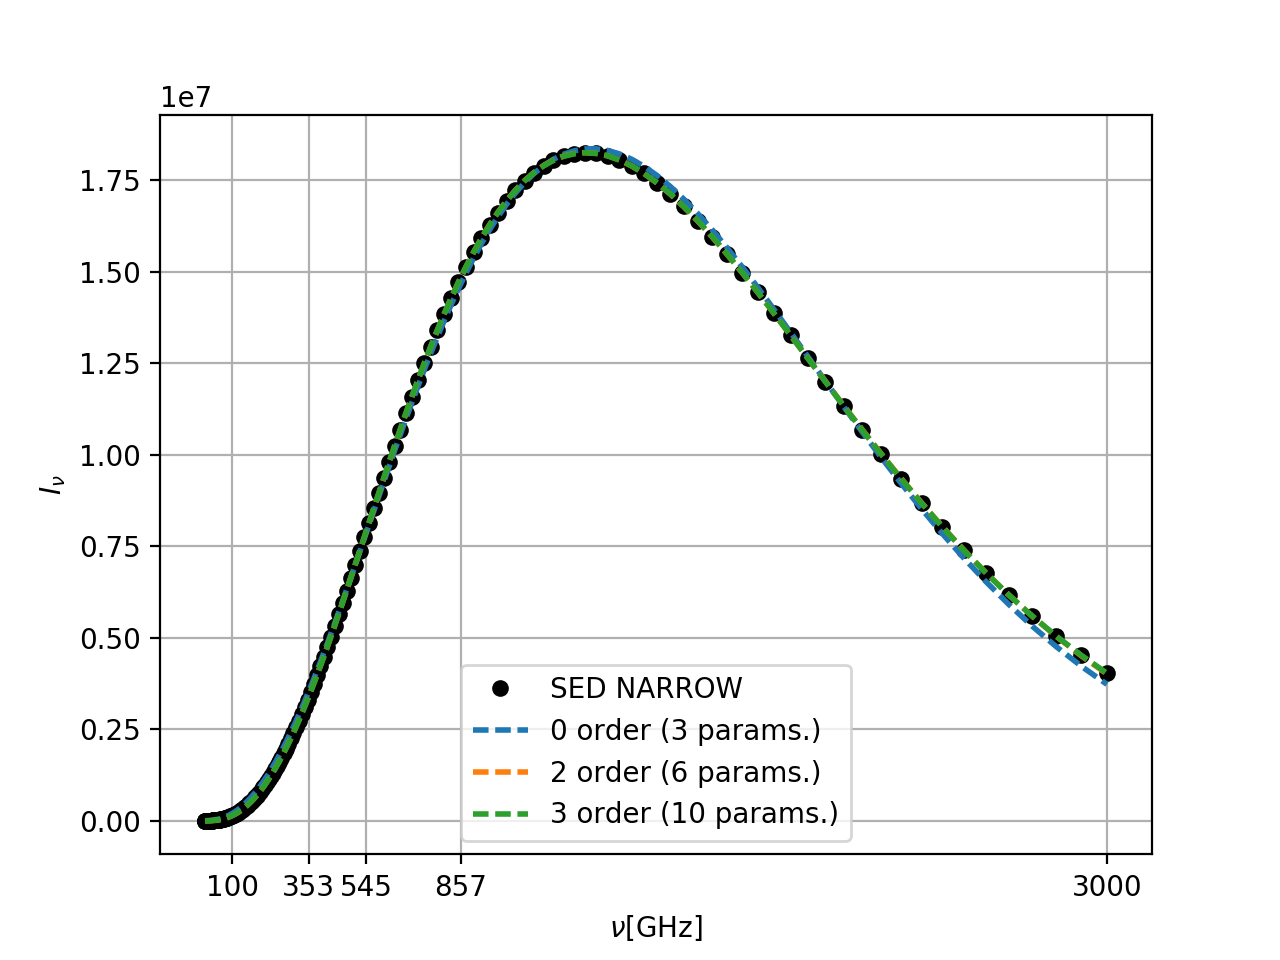

In [19]:
figure()
title("Improvement in fits to true spectrum with moment inclusion")
plot(nu,Inu_wide,"r-",lw=2,alpha=0.2)
plot(nu,Inu_narrow,"g-",lw=2,label="SED NARROW")
plot(nu,Inu_delta,"b-",lw=2,alpha=0.2)
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])),"--",lw=2,label=pllabel)
semilogy()
loglog()
grid()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
legend(loc=0)
savefig(pathout + "improvement_in_fits_narrow_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "improvement_in_fits_narrow_sed.jpeg",dpi=150,bbox_inches="tight")

figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$\Delta I_{\nu}/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
xticks([10,100,143,217,353,545,857,3000],[10,100,143,217,353,545,857,3000])
grid()
#ylim(1e-5,1e-1)
legend(loc=0,title="NARROW")
savefig(pathout + "relative_error_with_taylor_order_narrow_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order_narrow_sed.jpeg",dpi=150,bbox_inches="tight")


figure()
sl=0.
title("")
plot(nu,Inu/(nu**sl),"ko",mec="none",lw=4,alpha=1.,label="SED NARROW")
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
#ylabel(r"$I_{\nu}/ \nu^{3}$")
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])
savefig(pathout + "inu_fit_with_taylor_order_narrow_sed.pdf",dpi=150,bbox_inches="tight")

# Delta

In [10]:
Inu=zeros(size(nu),float) ; Inu[:] = Inu_delta[:]
p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=2.
p0=(5.,1.,1.,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

#p0=append(fitp1,(0.,0.,0.,0.))
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.)
lb2=append(lb1,[-prange,-prange,-prange,-prange])
ub2=append(ub1,[prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333), nu,Inu,p0,maxfev=2000000)#,bounds=[lb2,ub2],maxfev=200000)
print fitp2

[ 15.7          1.           0.10904494]
[  1.57000000e+01   1.00000000e+00   1.09044937e-01   2.84616198e-14
   3.94476779e-14  -5.43917732e-15]
[  1.45764086e+01   9.71988403e-01   1.13743458e-01   2.40839686e-02
   4.60670167e-02  -1.10176011e-03   1.91744588e-03  -1.52808296e-02
   1.41232968e-03   6.66651091e-04]


<IPython.core.display.Javascript object>


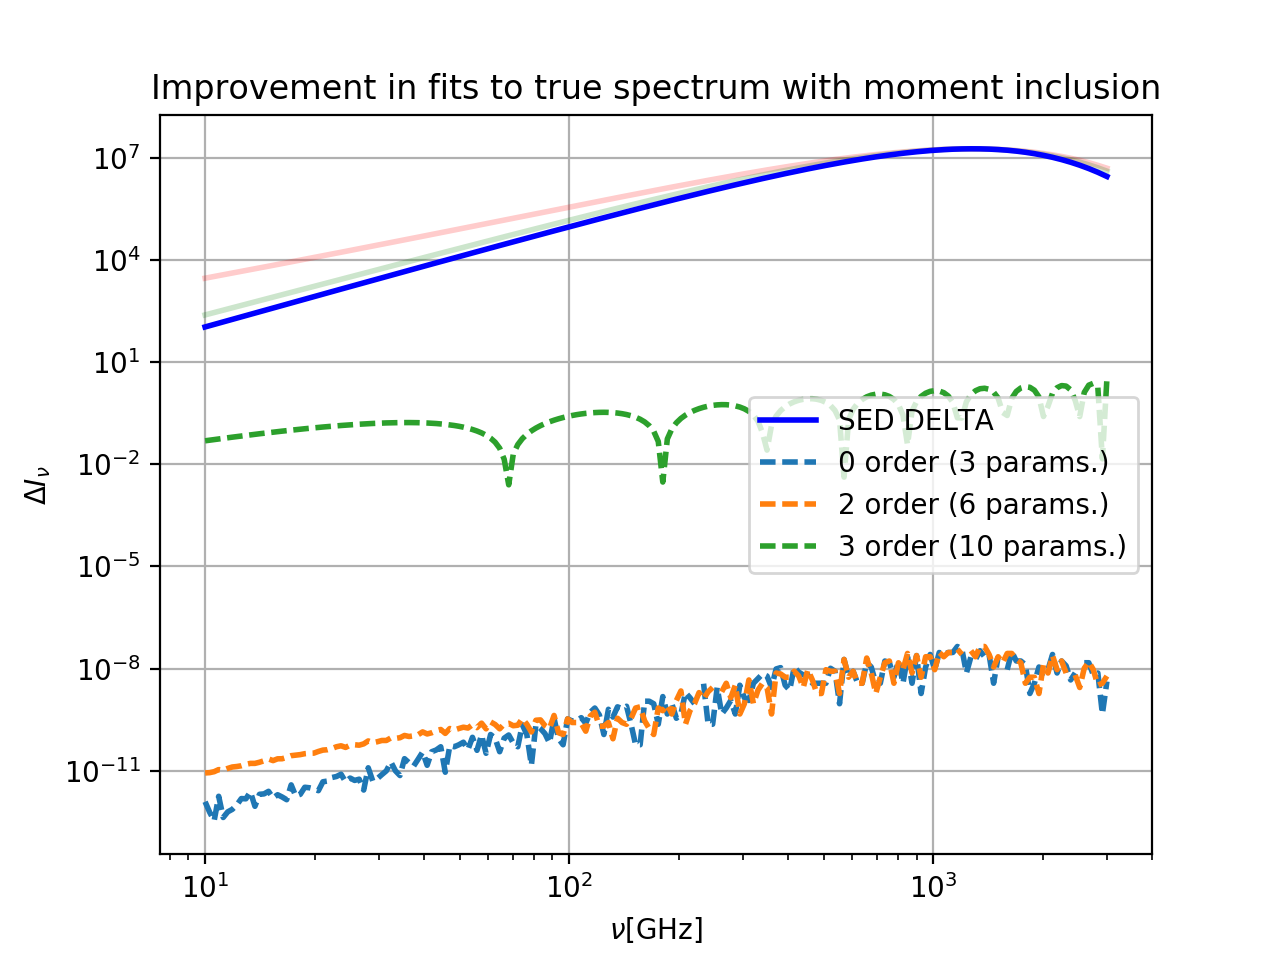

<IPython.core.display.Javascript object>


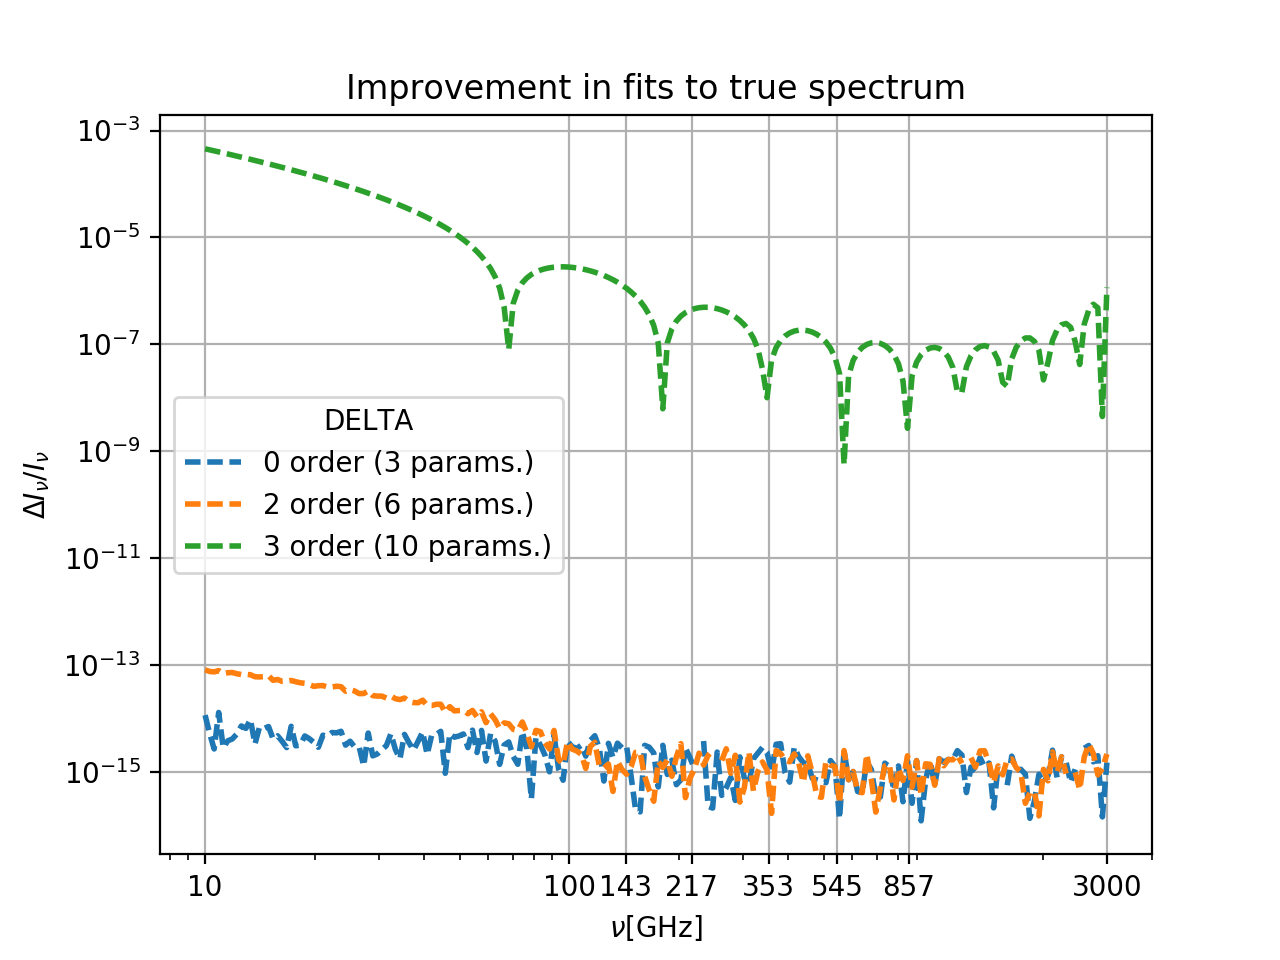

<IPython.core.display.Javascript object>


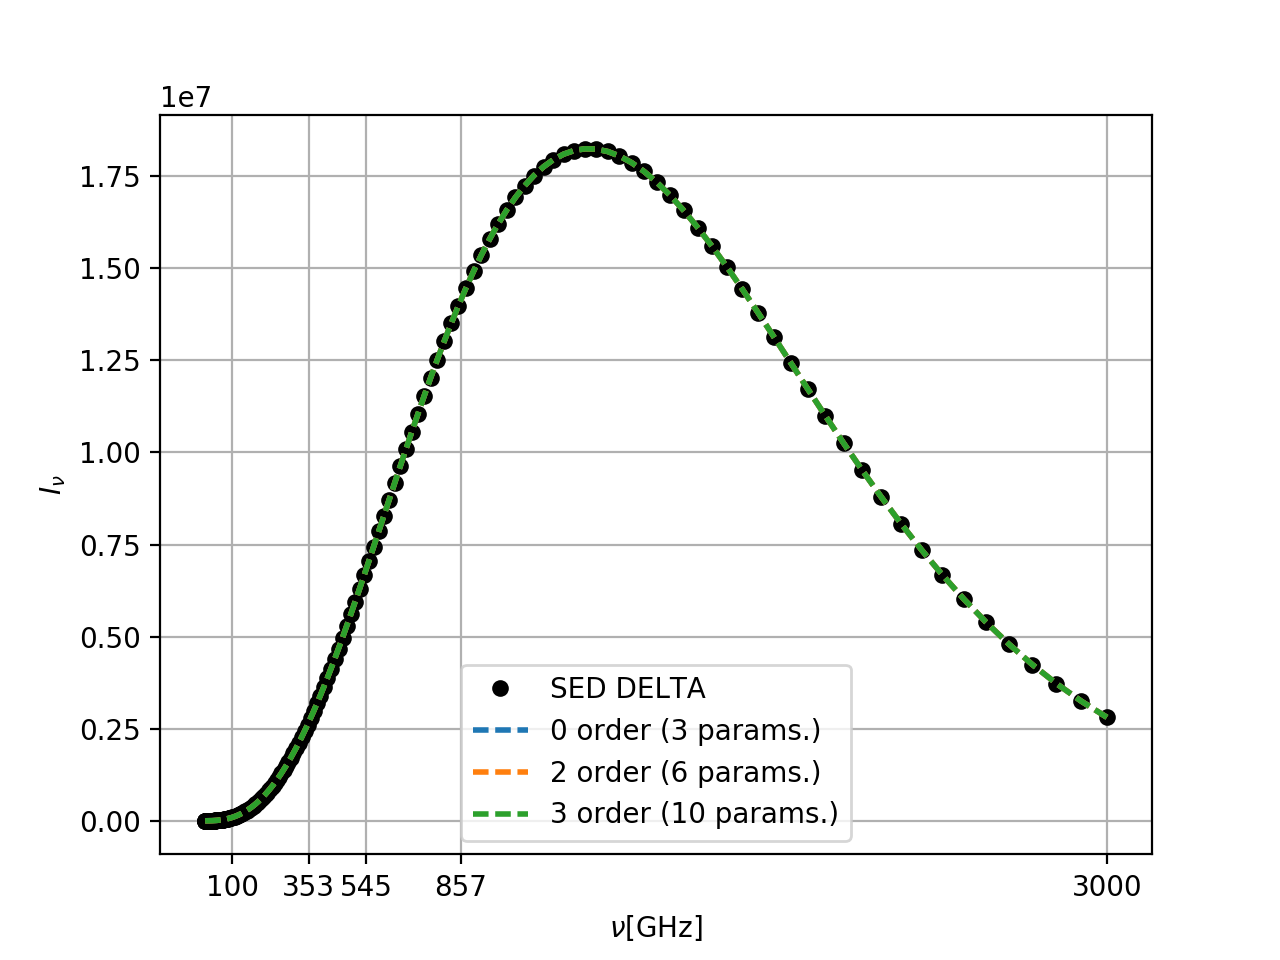

In [22]:
figure()
title("Improvement in fits to true spectrum with moment inclusion")
plot(nu,Inu_wide,"r-",lw=2,alpha=0.2)
plot(nu,Inu_narrow,"g-",lw=2,alpha=0.2)
plot(nu,Inu_delta,"b-",lw=2,label="SED DELTA")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])),"--",lw=2,label=pllabel)
semilogy()
loglog()
grid()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
legend(loc=0)
savefig(pathout + "improvement_in_fits_delta_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "improvement_in_fits_delta_sed.jpeg",dpi=150,bbox_inches="tight")

figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$\Delta I_{\nu}/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
xticks([10,100,143,217,353,545,857,3000],[10,100,143,217,353,545,857,3000])
grid()
#ylim(1e-5,1e-1)
legend(loc=0,title="DELTA")
savefig(pathout + "relative_error_with_taylor_order_delta_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order_delta_sed.jpeg",dpi=150,bbox_inches="tight")


figure()
sl=0.
title("")
plot(nu,Inu/(nu**sl),"ko",mec="none",lw=4,alpha=1.,label="SED DELTA")
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
#ylabel(r"$I_{\nu}/ \nu^{3}$")
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])
savefig(pathout + "inu_fit_with_taylor_order_delta_sed.pdf",dpi=150,bbox_inches="tight")